In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_04 import *
from functools import partial

## Initial setup

In [ ]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
loss_func = F.cross_entropy

In [ ]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs))

In [ ]:
#export
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [ ]:
learn = create_learner(get_model, loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.6828353125, tensor(0.7994)]
valid: [0.361650830078125, tensor(0.8887)]
train: [0.29670966796875, tensor(0.9128)]
valid: [0.234988916015625, tensor(0.9327)]
train: [0.23441919921875, tensor(0.9322)]
valid: [0.199171044921875, tensor(0.9455)]


In [ ]:
learn = create_learner(partial(get_model, lr=0.3), loss_func, data)
run = Runner([AvgStatsCallback([accuracy])])

run.fit(3, learn)

train: [0.74633921875, tensor(0.8078)]
valid: [0.33868505859375, tensor(0.9062)]
train: [0.341774453125, tensor(0.9029)]
valid: [0.288089111328125, tensor(0.9177)]
train: [0.28845693359375, tensor(0.9183)]
valid: [0.253452783203125, tensor(0.9284)]


In [ ]:
#export
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

## Annealing

In [ ]:
#export
class Recorder(Callback):
    def begin_fit(self, run):
        run.lrs=[]
        run.losses=[]
        run.stats=[]

    def after_batch(self, run):
        if run.in_train:
            run.lrs.append(run.opt.param_groups[-1]['lr'])
            run.losses.append(run.loss)        

def plot_lr  (run): plt.plot(run.lrs)
def plot_loss(run): plt.plot(run.losses)

In [ ]:
#export
class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self, run):
        for pg in run.opt.param_groups:
            pg[self.pname] = self.sched_func(run.n_epochs/run.epochs)
            
    def begin_batch(self, run): 
        if run.in_train: self.set_param(run)

In [ ]:
#export
import numpy as np

In [ ]:
def _sched_lin_val(start, end, pos): return start + pos*(end-start)
def sched_lin(start, end): return partial(_sched_lin_val, start, end)

In [ ]:
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

In [ ]:
@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [ ]:
f = sched_lin(1,2)

In [ ]:
@annealer
def sched_cos(start, end, pos): return start + math.cos(math.pi*(1-pos)/2.)*(end-start)
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

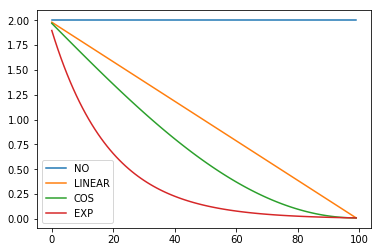

In [ ]:
annealings = "NO LINEAR COS EXP".split()

a = np.arange(0, 100)
p = np.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

In [ ]:
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    assert np.all(np.array(pcts) >= 0)
    pcts = np.cumsum([0] + pcts)
    def _inner(pos):
        idx = (pos >= pcts).nonzero()[0].max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [ ]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

In [ ]:
learn = create_learner(get_model_func(0.3), loss_func, data)
run = Runner([Recorder(), AvgStatsCallback([accuracy]), ParamScheduler('lr', sched)])

In [ ]:
run.fit(3, learn)

train: [0.643362578125, tensor(0.8068)]
valid: [0.2986107177734375, tensor(0.9153)]
train: [0.30859470703125, tensor(0.9109)]
valid: [0.2713834228515625, tensor(0.9197)]
train: [0.2827247265625, tensor(0.9164)]
valid: [0.22978662109375, tensor(0.9333)]


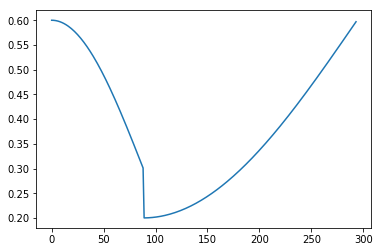

In [ ]:
plot_lr(run)

## Export

In [ ]:
!./notebook2script.py 05_anneal.ipynb

Converted 05_anneal.ipynb to nb_05.py
